# ACNets: Connectivity Classifier

This notebook fits a binary classifier to predict participant's group, AVGP or NVGP, using functional connectivity matrices. As input, it takes upper-triangular connectivity matrices for each participant.

To address the concerns about small sample size and test/train splits, results are evaluated using 5-fold cross-validated permutation testing.

## 0. Setup

In [1]:

import numpy as np
import xarray as xr
import pandas as pd

from IPython.display import clear_output
import matplotlib.pyplot as plt
import seaborn as sns; sns.set('poster')
import plotly.express as px

from sklearn import preprocessing, model_selection, metrics, ensemble, multioutput
from sklearn import decomposition, cross_decomposition, feature_selection, dummy, svm

from sklearn.pipeline import Pipeline
# from xgboost import XGBClassifier  # incompatible with umap's scipy

sns.set(style='dark')

# Technical reproducibility
%reload_ext watermark
%watermark -iv -co -ituhmv

Last updated: 2022-02-16T16:52:40.881962+01:00

Python implementation: CPython
Python version       : 3.9.10
IPython version      : 8.0.1

conda environment: acnets

Compiler    : Clang 11.1.0 
OS          : Darwin
Release     : 21.3.0
Machine     : x86_64
Processor   : i386
CPU cores   : 12
Architecture: 64bit

Hostname: MP0159

numpy     : 1.21.5
sklearn   : 1.0.2
pandas    : 1.4.0
plotly    : 5.5.0
xarray    : 0.21.1
matplotlib: 3.5.1
seaborn   : 0.11.2
sys       : 3.9.10 | packaged by conda-forge | (main, Feb  1 2022, 21:28:27) 
[Clang 11.1.0 ]



### Load the dataset

In [2]:
atlases = ['dosenbach2007', 'difumo_64_2', 'difumo_128_2',] # 'difumo_1024_2']


DATASETS = dict()

for atlas in atlases:
  DATASETS[atlas] = xr.open_dataset(f'data/julia2018_resting/connectivity_{atlas}.nc')

# selected data for the analysis
DEFAULT_ATLAS = 'difumo_64_2'
DEFAULT_DATASET = DATASETS[DEFAULT_ATLAS]
DEFAULT_CONNECTIVITY = DEFAULT_DATASET['tangent_connectivity'].values

## 2. Classification Model

-[ ] TODO: replicate https://www.frontiersin.org/articles/10.3389/fnhum.2014.00425/full

In [3]:
# ALT1: single-output classifiers, e.g., SVM, boosting
# model = svm.SVC(kernel='linear', C=1, probability=True)
# model =ensemble.AdaBoostClassifier(model, n_estimators=100, algorithm='SAMME.R')
# model =ensemble.GradientBoostingClassifier(n_estimators=100)

# ALT2: chance level
# model = dummy.DummyClassifier(strategy='uniform')

# ALT3: multi-output (classification + behavioral regression)
# model = multioutput.MultiOutputClassifier(ensemble.GradientBoostingClassifier())


pipeline = Pipeline([
    ('zerovar', feature_selection.VarianceThreshold()),
    # ('select', feature_selection.SelectKBest()),
    # ('rfe', feature_selection.RFE(svc)),
    # ('standard_scaler', preprocessing.StandardScaler()), 
    # ('reducer', UMAP(n_components=3)), 
    # ('reducer', decomposition.PCA()),
    # ('reducer', cross_decomposition.PLSCanonical()),    
    ('model', svm.SVC(kernel='rbf', C=1)),
], verbose=False)


param_grid = {
    # 'zerovar__threshold': [0],
    # 'select__k': np.linspace(1, X.shape[1], num=100, endpoint=True, dtype='int'),
    # 'rfe__n_features_to_select': [.1, .2, .5, 1.],
    # 'reducer__n_neighbors': [1, 2, 3, 4, 5, 10],  # UMAP
    # 'reducer__n_components': [2,3,5],  # UMAP
    # 'reducer__n_components': range(1, 30),  # PCA
    # 'model__n_estimators': [10, 100, 1000],  # XGBClassifier, GradientBoostingClassifier
    # 'model__estimator__n_estimators': [10, 100],  # MultiOutputClassifier
}

grid = model_selection.GridSearchCV(
    pipeline, param_grid,
    cv=model_selection.LeaveOneOut(),
    scoring='accuracy',
    # scoring=['accuracy', 'roc_auc', 'f1', 'precision', 'recall'], refit='accuracy',
    n_jobs=1, verbose=1,
)

# rfe_model = feature_selection.RFECV(grid)
# rfe_model.fit()

Now we tune the hyper-parameters and train the model. We then evaluate the fitted model on the held-out test data:

## 1. Data

In [4]:

perm_score_observed = {}
perm_scores = {}
perm_pvalue = {}

for ds_name, ds in DATASETS.items():

  # 1. input (vectorized connectivity matrix)
  connectivity = ds['tangent_connectivity'].values
  X = np.array([subj_conn[np.triu_indices_from(subj_conn)] for subj_conn in connectivity])

  # 1.1. threshold X
  X_threshold = np.median(X, axis=1) + np.std(X, axis=1)
  X = np.where(np.abs(X) >= X_threshold.reshape(-1,1), X, 0)

  # 2. output (AVGP vs NVGP encoded as integers)
  y_encoder = preprocessing.LabelEncoder()
  y = y_encoder.fit_transform(ds['group'])

  # 2.1. behavioral outputs (inverse efficiency scores in millis)
  y_beh = ds['inverse_efficiency_score_ms'].values

  # 3. remove subjects with missing behavioral data
  X = X[~np.isnan(y_beh)]
  y = y[~np.isnan(y_beh)]
  y_beh = y_beh[~np.isnan(y_beh)]

  # DEBUG
  print(f'{X.shape[1]} features, {X.shape[0]} subjects, {np.unique(y).shape[0]} class labels.')
  
  train, test = model_selection.train_test_split(
    range(len(X)),
    test_size=0.2,
    shuffle=True,
    stratify=y)

  # fit
  grid.fit(X[train], y[train])

  # evaluate
  score_train = grid.score(X[train], y[train])
  score_test = grid.score(X[test], y[test])

  # clear_output()

  # report scores and hyperparameters
  print(f'{ds_name} - train set score (roc_auc): {score_train:.2f}')
  print(f'{ds_name} - test set score (roc_auc): {score_test:.2f}')
  print('---------')
  
  print('Permutation testing...')
  
  perm_score_observed[ds_name], perm_scores[ds_name], perm_pvalue[ds_name] = model_selection.permutation_test_score(
    pipeline, X, y,
    cv=5, scoring='roc_auc',
    #cv=model_selection.LeaveOneOut(), scoring='accuracy',  # LOO cannot handle roc-auc
    n_permutations=1000, verbose=0)
  
  print('done.')
  

780 features, 32 subjects, 2 class labels.
Fitting 25 folds for each of 1 candidates, totalling 25 fits
dosenbach2007 - train set score (roc_auc): 1.00
dosenbach2007 - test set score (roc_auc): 0.42857142857142855
---------
2080 features, 32 subjects, 2 class labels.
Fitting 25 folds for each of 1 candidates, totalling 25 fits
difumo_64_2 - train set score (roc_auc): 1.00
difumo_64_2 - test set score (roc_auc): 0.42857142857142855
---------
8256 features, 32 subjects, 2 class labels.
Fitting 25 folds for each of 1 candidates, totalling 25 fits
difumo_128_2 - train set score (roc_auc): 1.00
difumo_128_2 - test set score (roc_auc): 0.5714285714285714
---------


## 3. Model Evaluation
Below is the confusion matrix of the classifier on the train and test sets.

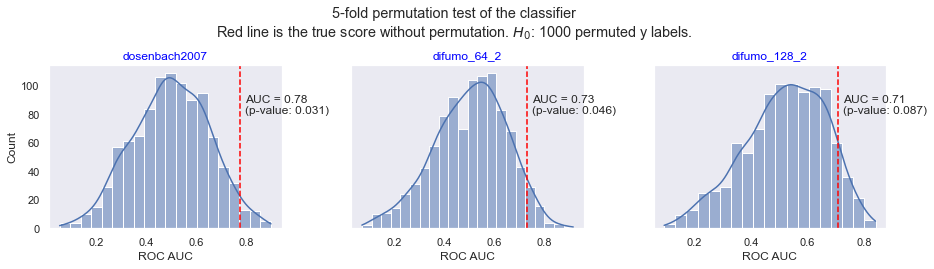

In [7]:

fig, axes = plt.subplots(1, len(DATASETS), sharey=True,
                         figsize=(15, 3),
                         gridspec_kw=dict(wspace=.3)
                         )

for i, ds_name in enumerate(DATASETS.keys()):
  g = sns.histplot(perm_scores[ds_name], kde=True, ax=axes[i])
  axes[i].axvline(perm_score_observed[ds_name], ls='--', color='red')

  axes[i].set(xlabel='ROC AUC')
  axes[i].text(x=perm_score_observed[ds_name] + .02,
               y=axes[i].get_ylim()[1] * .7,
            s=(f'AUC = {perm_score_observed[ds_name]:.2f}\n'
               f'(p-value: {perm_pvalue[ds_name]:.3f})'))
  
  axes[i].set_title(ds_name, color='blue')

plt.suptitle('5-fold permutation test of the classifier\n'
             'Red line is the true score without permutation. '
             '$H_0$: 1000 permuted y labels.', y=1.15)
plt.show()

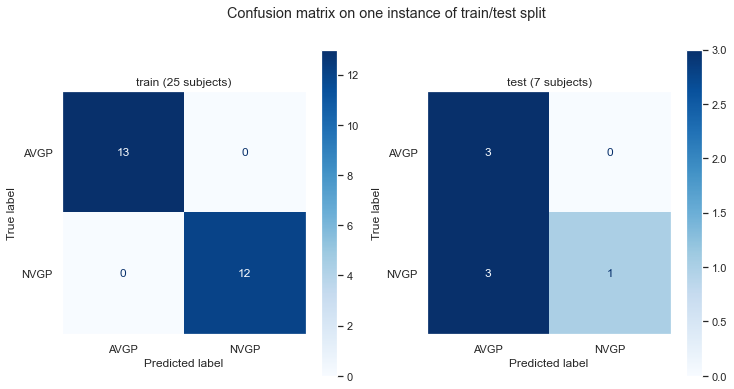

In [6]:
# FIXME does not work in the new version

# plot confusion matrix
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# train set
metrics.ConfusionMatrixDisplay.from_estimator(
  grid,
  X[train], y[train],
  # normalize='all',
  display_labels=y_encoder.classes_,
  ax=axes[0],
  cmap='Blues'
  )

# test set
metrics.ConfusionMatrixDisplay.from_estimator(
  grid,
  X[test], y[test],
  # normalize='all',
  display_labels=y_encoder.classes_,
  ax=axes[1],
  cmap='Blues'
  )

# set titles
axes[0].set(title=f'train ({len(train)} subjects)')
axes[1].set(title=f'test ({len(test)} subjects)')

plt.suptitle('Confusion matrix on one instance of train/test split')

plt.show()